# Notebook 3: Data Exploration

In this notebook we will explore the 'train.csv' created by the end of notebook 2.

In [1]:
#Importing the required libraries.
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = 1000
import seaborn as sns
from random import randrange
%matplotlib inline


In [2]:
#Loading the custom made libraries.
from preprocessCSV import *

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [3]:
train = pd.read_csv(r'Data/train.csv')
validate = pd.read_csv(r'Data/validation.csv')

In [4]:
#Making sure the dataset is of the correct dtype using the custom features from prepocessCSV.
for data in [train,validate]:
    data.drop(['Unnamed: 0'],axis =1, inplace =True)
    data = categorize_features(data)
    data = numerise_features(data)
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7342235 entries, 0 to 7342234
Data columns (total 15 columns):
 #   Column               Dtype   
---  ------               -----   
 0   day                  category
 1   hour                 category
 2   click                int32   
 3   browser              category
 4   os                   category
 5   ad_exchange          category
 6   ad_slot_width        int32   
 7   ad_slot_height       int32   
 8   ad_slot_visibility   category
 9   ad_slot              category
 10  ad_slot_floor_price  int32   
 11  bidding_price        int32   
 12  paying_price         int32   
 13  advertiser_id        category
 14  region_id            category
dtypes: category(9), int32(6)
memory usage: 231.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447412 entries, 0 to 2447411
Data columns (total 15 columns):
 #   Column               Dtype   
---  ------               -----   
 0   day                  category
 1   hour            

* Above we have an overview of the various features and their datatypes. 
* We will define a function to print out the stats and other kPI's of the RTB such as Click Through Rate (CTR), Cost Per Click (CPC).

In [5]:
#Utilities.
def describe_feature(data, feature, min_bid=False):
    '''
    A method that provides the stat analysis of feature 
    given as input in the context of the data.
    
    Args: data -> pd.DataFrame
             
          feature -> str
    '''
    #Checking tthe validity of the feature.
    if feature not in data.columns:
        print('Hey you!, give a valid feature to describe!!!')
        return
    stats = pd.DataFrame()

    #data_ = data[feature].astype('int32')

    #Creting a feature groupby object.
    feat_grp = data.sort_values([feature]).groupby([feature])

    #Column for the feature of interest values.
    stats[feature] = np.sort(data[feature].unique())

    #Number of impressions.
    n_imps = feat_grp.apply(lambda x: x.shape[0])
    stats['Impressions'] = n_imps.values
    
    #Number of clicks.
    n_clicks = feat_grp['click'].apply(lambda x: x.sum())
    stats['Clicks'] = n_clicks.values
    
    #Cost.
    cost = feat_grp['paying_price'].unique().apply(lambda x: x.sum())
    stats['Cost'] = cost.values
    
    
    #Click through Rate.
    CTR = (n_clicks / n_imps) * 100
    stats['CTR'] = CTR.values

    #CPM.
    CPM = cost/n_imps
    stats['CPM'] = CPM.values
    
    #CPC.
    stats['CPC'] = stats['Cost']/stats['Clicks']
    

    #Minimum Bidding price.
    if min_bid:
        min_bid = feat_grp['bidding_price'].apply(lambda x: x.min())
        stats['Minimum Bid'] = min_bid.values

    return stats

def is_pattern(data,cat1,cat2,size =(11.7,8.27)):
    '''
    A method that takes in two categorical features from data and 
    produces a dataframe that can be used as a grid 
    for heatmap of number of clicks.
    
    Args :   data -> dataframe(pd.DataFrame) 
                The data in which pattern is to be found.
             cat1,cat2 -> (str)
                 Categorical feature names.
             size -> (tuple)
                 Size of the heatmap grid.
    '''
    stats = pd.DataFrame()
    #The coulmns of interest.
    cols = ['click', cat1, cat2]
    
    #A checkpoint.
    if set(cols).issubset(data.columns):
        data = data[cols]
    else:
        print(f'The features given as input doesnot exist in the data.')
    
    cat1_grp = data.sort_values([cat1]).groupby(cat1)
    
    for cat1_val in data[cat1].unique():
        #Getting a dataframe of a particular value of category one.
        df = cat1_grp.get_group(cat1_val)
        #Category 2 groupby object.
        cat2_grp = df.sort_values([cat2]).groupby(cat2)
        #Counting the number of clicks.
        cat2_clks = cat2_grp['click'].apply(lambda x: x.sum())
        stats[cat1_val] = cat2_clks
    sns.set(rc={'figure.figsize':size})
    heatmap = sns.heatmap(stats,annot = True,linewidths=.5)
    return heatmap

---
---

## advertiser_id

* The given dataset has five advertisers and they are denoted by their unique id's.
* The various advertisers and their overall stats are,



  Term |Description
---|---
CTR | Click Through Rate. Defined as the ratio of total number of clicks received and the total number of impressions made.
Cost | Total amount spend by the advertiser.
CPM | Cost Per Mille. Ratio of total amount spend by the total number of bids won (impressions).
CPC | Effective Cost per Click. Ratio of total amount spend by the advertiser and the number of clicks received.



Higher the CTR, better is the bidding strategy and in case of
CPC, the more lower, the better it is because our goal is to max-
imize the number of clicks by the user on the advertisements and
minimize the amount spent by each advertiser. 


In [6]:
adv_stat = describe_feature(train,feature='advertiser_id')
desc = adv_stat[['Impressions','Clicks','CTR']].describe()
display('adv_stat','desc')

adv_stat
   advertiser_id  Impressions  Clicks   Cost       CTR       CPM        CPC
0           1458      1849308    1287  45149  0.069594  0.024414  35.080808
1           3358      1046307     741  35357  0.070821  0.033792  47.715250
2           3386      1708232    1089  45150  0.063750  0.026431  41.460055
3           3427      1556699    1039  35581  0.066744  0.022857  34.245428
4           3476      1181689     534  35554  0.045190  0.030087  66.580524

desc
        Impressions       Clicks       CTR
count  5.000000e+00     5.000000  5.000000
mean   1.468447e+06   938.000000  0.063220
std    3.430644e+05   298.675409  0.010443
min    1.046307e+06   534.000000  0.045190
25%    1.181689e+06   741.000000  0.063750
50%    1.556699e+06  1039.000000  0.066744
75%    1.708232e+06  1089.000000  0.069594
max    1.849308e+06  1287.000000  0.070821

**Observations:**

* The CTR's in all 7 days are very low ranging from $0.045190\% - 0.070821\%$. 
* Althought all advertiser have a similar CPM they have varying CPC. This could indicate the difference in the markets of interest of different advertisers.

**Advertisers clicks distribution across various days of the week:**
* This can be better understood as a heatmap.
* If there is a pattern hiding data heatmap captures it.

<AxesSubplot:ylabel='day'>

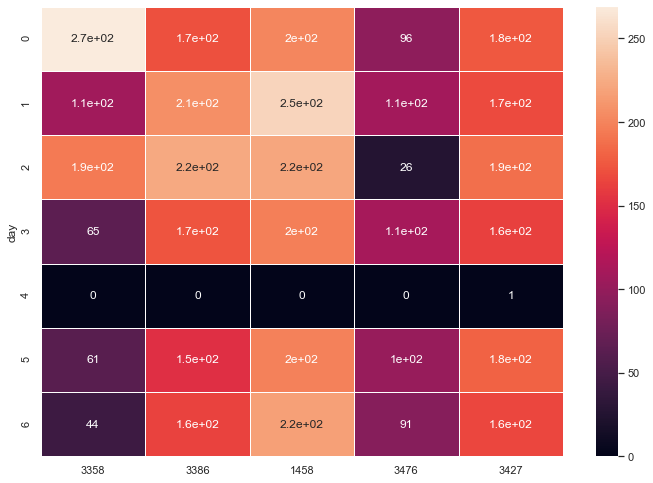

In [7]:
is_pattern(train,'advertiser_id','day')

* As can be seen different advertisers have different distributions for various days.
* An instance would be Advertiser 1458 has the highest number of clicks on monday whereas advertiser 3358 has the highest number of clicks on sunday.
* All advertisers have very less clicks on thursday, this might lead to bias in any models trained using this dataset.
---

**Distribution of clicks over devices:**

<AxesSubplot:ylabel='browser'>

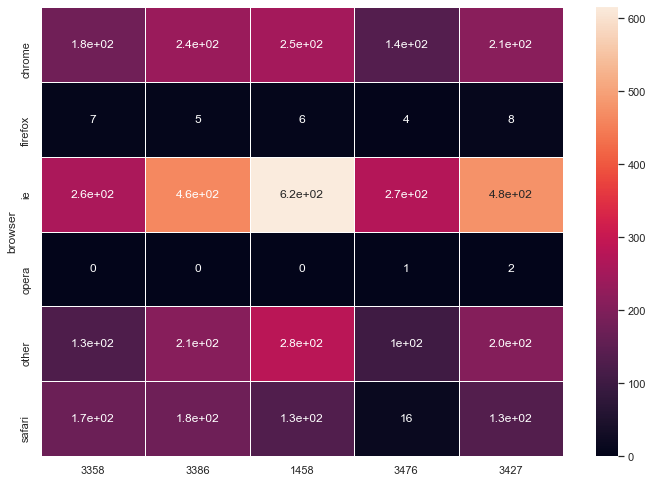

In [8]:
is_pattern(train,'advertiser_id','browser')

<AxesSubplot:ylabel='os'>

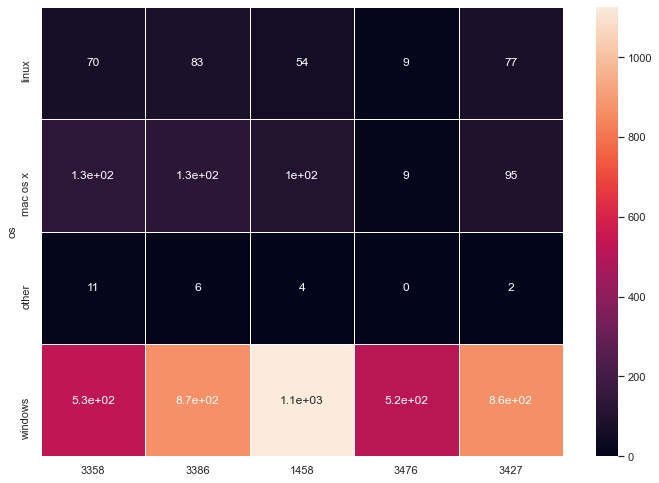

In [9]:
is_pattern(train,'advertiser_id','os')

* Advertiser 1458 has recieved majority of the clicks from users having a windows operating system. This might have lead to the bias of the majority clciks for 1458 to have come from the internet explorer (ie) borwser.

<AxesSubplot:ylabel='region_id'>

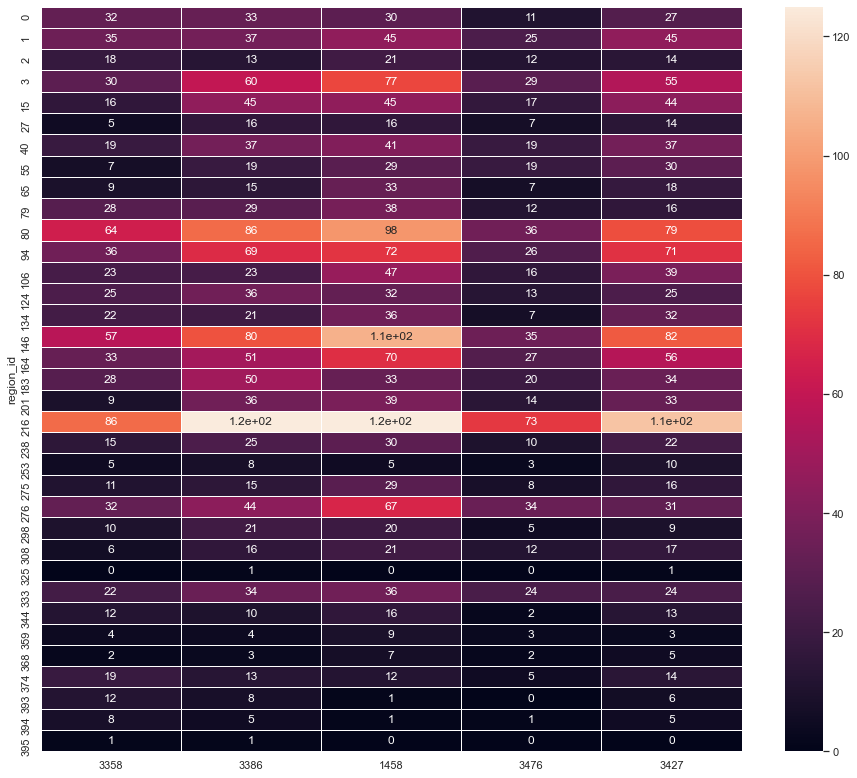

In [10]:
is_pattern(train,'advertiser_id','region_id',size = (15.7,13.7))

* Even the regions where the advertisers get maximum number of clicks are significantly diffferent. 
* Due to this difference in clicks reacieved for same feature it makes more sense to train different models for different advertisers.
* For our studies we will use the data for the advertiser 1458 based solely on the availability of more data points for the advertiser.

In [11]:
#Making the training dataset and validation dataset for advertiser 1458.
adv_grp = train.groupby(['advertiser_id'])
train_1458 = adv_grp.get_group(1458).copy(deep=True)
train_1458.drop(['advertiser_id'],axis=1,inplace=True)
train_1458.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1849308 entries, 4 to 7342234
Data columns (total 14 columns):
 #   Column               Dtype   
---  ------               -----   
 0   day                  category
 1   hour                 category
 2   click                int32   
 3   browser              category
 4   os                   category
 5   ad_exchange          category
 6   ad_slot_width        int32   
 7   ad_slot_height       int32   
 8   ad_slot_visibility   category
 9   ad_slot              category
 10  ad_slot_floor_price  int32   
 11  bidding_price        int32   
 12  paying_price         int32   
 13  region_id            category
dtypes: category(8), int32(6)
memory usage: 70.5 MB


In [12]:
#Making the training dataset and validation dataset for advertiser 1458.
adv_grp = validate.groupby(['advertiser_id'])
validate_1458 = adv_grp.get_group(1458).copy(deep=True)
validate_1458.drop(['advertiser_id'],axis=1,inplace=True)
validate_1458.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617069 entries, 6 to 2447409
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   day                  617069 non-null  category
 1   hour                 617069 non-null  category
 2   click                617069 non-null  int32   
 3   browser              617069 non-null  category
 4   os                   617069 non-null  category
 5   ad_exchange          617069 non-null  category
 6   ad_slot_width        617069 non-null  int32   
 7   ad_slot_height       617069 non-null  int32   
 8   ad_slot_visibility   617069 non-null  category
 9   ad_slot              617069 non-null  category
 10  ad_slot_floor_price  617069 non-null  int32   
 11  bidding_price        617069 non-null  int32   
 12  paying_price         617069 non-null  int32   
 13  region_id            617069 non-null  category
dtypes: category(8), int32(6)
memory usage: 23.5 MB


In [13]:
#Writing them as csv files.
train_1458.to_csv('Data/train_1458.csv')
validate_1458.to_csv('Data/validate_1458.csv')

---
---

## Feature Extraction
 
Some features can be better modified to meet our needs. This section does exactly that. The code below will be stored as 'featurize.py' for later use.

### ad_slot_floor_price

* This is the minimum amount an advertiser has to pay to get the ad slot in auction.

In [14]:
fp_stats = describe_feature(train_1458,'ad_slot_floor_price')
desc = fp_stats[['Impressions','CTR']].describe()
display('fp_stats','desc')

fp_stats
     ad_slot_floor_price  Impressions  Clicks   Cost       CTR         CPM  \
0                      0       622507     401  45149  0.064417    0.072528   
1                      4        28282       6  44608  0.021215    1.577258   
2                      5       414838     291  45140  0.070148    0.108814   
3                      6           29       0   2673  0.000000   92.172414   
4                      7            2       0    211  0.000000  105.500000   
..                   ...          ...     ...    ...       ...         ...   
160                  290            1       0    289  0.000000  289.000000   
161                  292            3       0    292  0.000000   97.333333   
162                  294            9       0    589  0.000000   65.444444   
163                  295          282       0   1188  0.000000    4.212766   
164                  300            1       0    299  0.000000  299.000000   

             CPC  
0     112.591022  
1    7434.666667  
2     155.120275  
3            inf  
4            inf  
..           ...  
160          inf  
161          inf  
162          inf  
163          inf  
164          inf  

[165 rows x 7 columns]

desc
         Impressions         CTR
count     165.000000  165.000000
mean    11207.927273    0.015385
std     63566.819669    0.055070
min         1.000000    0.000000
25%         2.000000    0.000000
50%         8.000000    0.000000
75%       176.000000    0.000000
max    622507.000000    0.529101

* As can be seen, the different slots will have different user preferences and hence differnt CTR values.
* To reduce the dimesions of thefeature space we divide the floor prices in to differnt bins.
* Doing so also converts the continuos variable of floor price in to a category variable.

In [15]:
def make_floorprice_bins(df, nbins=10):
    '''
    A method that makes bins out of floor price values.
    '''
    bins = pd.DataFrame()
    labels = np.arange(1, nbins+1, 1)

    #Cutting up the floor price into bins.
    bins['floorprice_bin'] = pd.cut(df['ad_slot_floor_price'].values,
                                    bins=nbins,
                                    labels=labels)

    #Dropping the old feature.
    df = df.drop(columns=['ad_slot_floor_price'], axis=1)
    df['floorprice_bin'] = bins['floorprice_bin'].values
    bins.pop('floorprice_bin')
    return df

In [19]:
train_1458 = make_floorprice_bins(train_1458)
train_1458.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1849308 entries, 4 to 7342234
Data columns (total 14 columns):
 #   Column              Dtype   
---  ------              -----   
 0   day                 category
 1   hour                category
 2   click               int32   
 3   browser             category
 4   os                  category
 5   ad_exchange         category
 6   ad_slot_width       int32   
 7   ad_slot_height      int32   
 8   ad_slot_visibility  category
 9   ad_slot             category
 10  bidding_price       int32   
 11  paying_price        int32   
 12  region_id           category
 13  floorprice_bin      category
dtypes: category(9), int32(5)
memory usage: 65.3 MB


### Indicatorise Features:

* We can convert the category features in to indicator variables. This process is referred to as 'one-hot-encoding' in literature.

In [20]:
from pandas import get_dummies
def indicatorise_features(df,
                          category_features=[
                              'day', 'hour', 'browser', 'os', 'ad_exchange',
                              'ad_slot_visibility', 'ad_slot', 'region_id',
                              'floorprice_bin'
                          ]):
    '''
    A method that does one hot encoding on categorical features.
    '''
    dummies = {}
    for feature in category_features:
        dummies[feature] = get_dummies(df[feature], prefix=feature)
    df = df.join(list(dummies.values()))
    df.drop(columns=category_features, axis=1, inplace=True)
    return df

In [21]:
train_1458 = indicatorise_features(train_1458)
train_1458

click  ad_slot_width  ad_slot_height  bidding_price  paying_price  \
4            0            336             280            300            17   
15           0           1000              90            300            80   
20           0            300             250            300            50   
23           0           1000              90            300            70   
27           0            160             600            300            30   
...        ...            ...             ...            ...           ...   
7342214      0            468              60            300             5   
7342221      0            160             600            300           162   
7342231      0           1000              90            300            70   
7342232      0            336             280            300            51   
7342234      0            300             250            300            64   

         day_0  day_1  day_2  day_3  day_4  day_5  day_6  hour_0  hour_1  \
4            0      0      1      0      0      0      0       0       0   
15           0      0      0      0      0      1      0       0       0   
20           0      0      0      0      0      0      1       0       0   
23           0      1      0      0      0      0      0       0       0   
27           0      1      0      0      0      0      0       0       0   
...        ...    ...    ...    ...    ...    ...    ...     ...     ...   
7342214      0      0      0      1      0      0      0       0       0   
7342221      1      0      0      0      0      0      0       0       0   
7342231      1      0      0      0      0      0      0       0       0   
7342232      0      0      0      0      1      0      0       0       0   
7342234      0      0      0      1      0      0      0       0       0   

         hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  hour_9  \
4             0       0       0       0       0       0       0       0   
15            0       0       0       0       1       0       0       0   
20            0       1       0       0       0       0       0       0   
23            0       0       0       0       0       0       0       0   
27            0       0       0       0       0       0       0       0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
7342214       1       0       0       0       0       0       0       0   
7342221       0       0       0       0       0       0       0       0   
7342231       0       0       0       0       0       0       0       0   
7342232       0       0       0       0       0       0       0       0   
7342234       0       0       0       0       0       0       0       0   

         hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  hour_16  \
4              0        0        0        0        0        0        0   
15             0        0        0        0        0        0        0   
20             0        0        0        0        0        0        0   
23             0        0        0        0        0        0        0   
27             0        0        0        0        0        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
7342214        0        0        0        0        0        0        0   
7342221        0        0        0        0        0        0        0   
7342231        0        0        0        0        0        0        0   
7342232        0        0        0        0        0        0        0   
7342234        0        0        1        0        0        0        0   

         hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  \
4              0        0        0        0        0        1        0   
15             0        0        0        0        0        0        0   
20             0        0        0        0        0        0        0   
23             0        0        0        0        0        1        0   

In [22]:
#Both the methods combined.
def featurise_data(data):
    '''
    Featurises the data passed as a dataframe.
    '''
    #Floor price feature.
    data = make_floorprice_bins(data)
    #Indicatrise the variables.
    data = indicatorise_features(data)
    return data